In [3]:
# Import libraries and packages
import matplotlib as plt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os
import time   
import warnings
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

In [ ]:
!gdown 1AeOPro_4iCnbQcIPlZj6p5ko8gOy6LGa
!unzip train_images.zip

In [39]:
print("loading images...")
time1 = time.time()   # to measure time taken
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('train_images')))   # data folder with 3 categorical folders
random.seed(SEED)
random.shuffle(imagePaths)

loading images...


In [40]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, resize the image to be 32x32 pixels (ignoring aspect ratio), 
    # flatten the 32x32x3=3072 pixel image into a list, and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (32, 32)).flatten()
    data.append(image)
 
    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
print("done")

Time taken: 8.9 seconds
done


Split data for training and validation

In [41]:
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=SEED)

In [42]:
trainY

array(['1', '1', '2', ..., '3', '1', '1'], dtype='<U1')

In [43]:
# convert the labels from integers/categories to vectors 
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
testY = lb.transform(testY)         # transform = perform the one-hot encoding (unique class labels already found)

In [44]:
len(lb.classes_)

6

Define neural network architecture using Keras


In [45]:
# define the 3072-1024-512-6 architecture using Keras

model = Sequential()   # input layer 3072 as there are 32x32x3=3072 pixels in a flattened input image
model.add(Dense(1024, input_shape=(3072,), activation="relu"))   
model.add(Dense(512, activation="relu"))                         
model.add(Dense(len(lb.classes_), activation="softmax"))    

In [46]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              3146752   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 3,674,630
Trainable params: 3,674,630
Non-trainable params: 0
_________________________________________________________________


In [47]:
# initial learning rate and # of epochs 
INIT_LR = 0.01
EPOCHS = 100

print("training network...")

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the neural network on training data set
time1 = time.time()  
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   

training network...
Epoch 1/100
815/815 [==============================] - 5s 5ms/step - loss: 1.0018 - accuracy: 0.6162 - val_loss: 0.7939 - val_accuracy: 0.6902
Epoch 2/100
815/815 [==============================] - 3s 4ms/step - loss: 0.8299 - accuracy: 0.6770 - val_loss: 0.8078 - val_accuracy: 0.6728
Epoch 3/100
815/815 [==============================] - 4s 5ms/step - loss: 0.7650 - accuracy: 0.7078 - val_loss: 0.6964 - val_accuracy: 0.7444
Epoch 4/100
815/815 [==============================] - 4s 4ms/step - loss: 0.7012 - accuracy: 0.7374 - val_loss: 0.6934 - val_accuracy: 0.7339
Epoch 5/100
815/815 [==============================] - 3s 4ms/step - loss: 0.6476 - accuracy: 0.7576 - val_loss: 1.0011 - val_accuracy: 0.6555
Epoch 6/100
815/815 [==============================] - 3s 4ms/step - loss: 0.6298 - accuracy: 0.7655 - val_loss: 0.6818 - val_accuracy: 0.7336
Epoch 7/100
815/815 [==============================] - 4s 5ms/step - loss: 0.5902 - accuracy: 0.7775 - val_loss: 0.5648 - 

Evaluate Model

In [48]:
print("evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

evaluating network...
204/204 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           1       0.94      0.93      0.94      2720
           2       0.84      0.88      0.86      2231
           3       0.74      0.74      0.74       934
           4       0.85      0.79      0.81        14
           5       0.78      0.69      0.73       613
           7       0.00      0.00      0.00         1

    accuracy                           0.86      6513
   macro avg       0.69      0.67      0.68      6513
weighted avg       0.86      0.86      0.86      6513



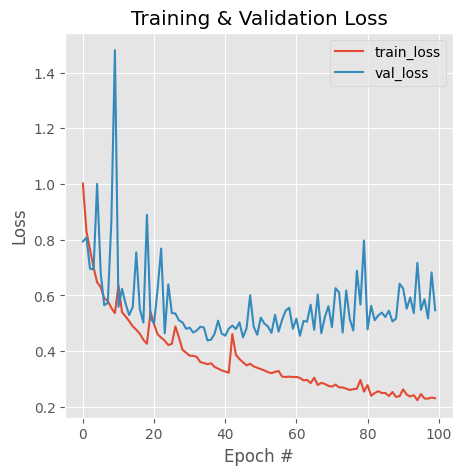

In [49]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [5,5])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

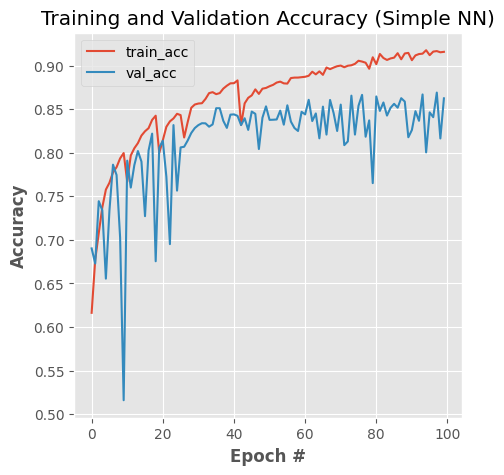

In [52]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [5,5])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Simple NN)")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()